In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

/tmp/ipykernel_97959/2900625769.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
from utils.plotting import *
from utils.plotting import cfg as cfg_plt
import utils.plotting as plotting

import numpy as np
import h5py
import matplotlib.pyplot as plt
import importlib

100%|██████████| 30/30 [00:00<00:00, 278.49it/s]


## Calculate num points in the point clouds, and occupancy

In [3]:
## NEEDS TO BE THE x36 POINT CLOUD / SAME AS TRAINING DATA

path = 'BEEGFS/data/calo-clouds/hdf5/high_granular_grid/validation/10-90GeV_x36_grid_regular_float32.hdf5' # real point clouds 
real_showers = h5py.File(path, 'r')['events'][:]
real_showers[:, -1] = real_showers[:, -1] * 1000   # GeV to MeV

print(len(real_showers))

# only necessary if z axis of data not in absolute coordiantes, but in layer coordinates
# pos = np.linspace(0, 30, 31)
# for i in tqdm(range(30)):
#     idx = np.where((real_showers[:, 1] > pos[i]) & (real_showers[:, 1] < pos[i+1]))
#     real_showers[:, 1][idx] = layer_bottom_pos[i] + cell_thickness/2

40000


In [234]:
# for n hits calibration (n_scaling=False)   # FINAL
# fake_showers = np.load('BEEGFS/6_PointCloudDiffusion/output/CCbaseline_10-90GeV_40k.npy')  # seed 1234  # new flow: 220714_cog_e_layer_ShowerFlow_best
# fake_showers = np.load('BEEGFS/6_PointCloudDiffusion/output/kCaloClouds_2023_06_29__23_08_31_ckpt_0.000000_2000000_10-90GeV_40k.npy')  # seed 1234 num_steps = 13, simga_max 80 # new flow: 220714_cog_e_layer_ShowerFlow_best
fake_showers = np.load('BEEGFS/6_PointCloudDiffusion/output/CD_2023_07_07__16_32_09_ckpt_0.000000_1000000_10-90GeV_40k.npy')  # seed 1234 simga_max 80 # new flow: 220714_cog_e_layer_ShowerFlow_best

print(fake_showers.shape)


(100000, 4, 6000)


In [235]:
n = 100_000
importlib.reload(plotting)

events = plotting.get_projections(real_showers[:n], MAP, layer_bottom_pos)       # get projection of a point clouds to the detector grid
events_fake = plotting.get_projections(fake_showers[:n], MAP, layer_bottom_pos)  # get projection of a point clouds to the detector grid

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [07:04<00:00, 235.51it/s]


In [236]:
importlib.reload(plotting)

_, occ_real, _, _, _, _, _, _, _ = plotting.get_features(events)      # get event level features
_, occ_fake, _, _, _, _, _, _, _ = plotting.get_features(events_fake) # get event level features

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [04:23<00:00, 379.85it/s]


In [237]:
num_hits_real = (real_showers[:, -1, :] > 0).sum(axis=1)  # get num points in the point clouds
num_hits_fakel = (fake_showers[:, -1, :] > 0).sum(axis=1) # get num points in the point clouds

# polynomial fit

In [240]:
coef = np.polyfit(num_hits_real, occ_real, 3)
poly1d_fn = np.poly1d(coef)

coef_2 = np.polyfit(occ_fake, num_hits_fakel, 3)
poly1d_fn_2 = np.poly1d(coef_2) 

In [241]:
poly1d_fn   # coef_real

poly1d([ 2.42091454e-09, -2.72191705e-05,  2.95613817e-01,  4.88328360e+01])

In [242]:
poly1d_fn_2   # coef_fake

poly1d([-9.22923201e-07,  2.88543976e-03,  9.62671690e-01,  1.78354290e+02])

In [243]:
poly1d_fn_2(poly1d_fn(3000)) / 3000       

0.7189125702882477

# spline fit

In [262]:
from sklearn.linear_model import HuberRegressor
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer, StandardScaler
from sklearn.pipeline import make_pipeline

knots = np.quantile(num_hits_real, np.arange(0.1, 0.91, 0.1)).reshape(-1,1)
spline_real = make_pipeline(SplineTransformer(n_knots=9, degree=1, knots=knots, extrapolation='linear'), HuberRegressor(max_iter=1000))
spline_real.fit(num_hits_real[:].reshape(-1,1), occ_real[:].reshape(-1))

knots = np.quantile(occ_fake, np.arange(0.1, 0.91, 0.2)).reshape(-1,1)
spline_fake = make_pipeline(SplineTransformer(n_knots=9, degree=2, knots=knots, extrapolation='linear'), HuberRegressor(max_iter=1000))
spline_fake.fit(occ_fake[:].reshape(-1,1), num_hits_fakel[:].reshape(-1))

Pipeline(steps=[('splinetransformer',
                 SplineTransformer(degree=2, extrapolation='linear',
                                   knots=array([[ 522.],
       [ 783.],
       [ 997.],
       [1183.],
       [1377.]]),
                                   n_knots=9)),
                ('huberregressor', HuberRegressor(max_iter=1000))])

# Plot fit

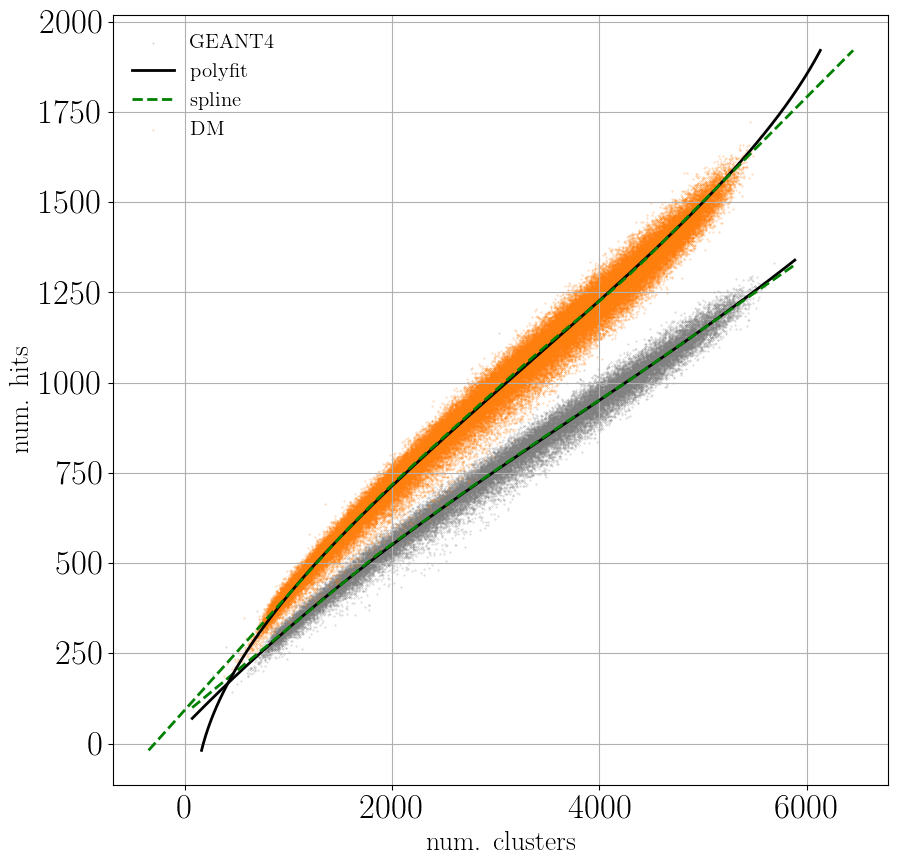

In [263]:
plt.figure(figsize=(10, 10))
x = 200

plt.scatter(num_hits_real, occ_real, s=0.1, alpha=0.5, label='GEANT4', color='grey')
plt.plot(np.arange(num_hits_real.min()-x, num_hits_real.max()+x), poly1d_fn(np.arange(num_hits_real.min()-x, num_hits_real.max()+x)), '-k', lw=2, label='polyfit')
plt.plot(np.arange(num_hits_real.min()-x, num_hits_real.max()+x), spline_real.predict(np.arange(num_hits_real.min()-x, num_hits_real.max()+x).reshape(-1,1)), '--g', lw=2, label='spline')

plt.scatter(num_hits_fakel, occ_fake, s=0.1, alpha=0.5, label='DM', color='tab:orange')
plt.plot(poly1d_fn_2(np.arange(occ_fake.min()-x, occ_fake.max()+x)), np.arange(occ_fake.min()-x, occ_fake.max()+x), 'k', lw=2)
plt.plot(spline_fake.predict(np.arange(occ_fake.min()-x, occ_fake.max()+x).reshape(-1,1)), np.arange(occ_fake.min()-x, occ_fake.max()+x), '--g', lw=2)


plt.grid('both')
plt.ylabel('num. hits', fontsize=20, family='serif')
plt.xlabel('num. clusters', fontsize=20, family='serif')
# plt.xlim(150, 1200)
# plt.ylim(400, 3700)
plt.legend(fontsize=15)
plt.show()

In [264]:
# import joblib

# spline_folder = 'BEEGFS/6_PointCloudDiffusion/n_spline/'
# spline_dict = {'spline_real': spline_real, 'spline_fake': spline_fake}

# # joblib.dump(spline_dict, spline_folder + 'spline_ddpm.joblib')
# # joblib.dump(spline_dict, spline_folder + 'spline_edm.joblib')
# # joblib.dump(spline_dict, spline_folder + 'spline_cm.joblib')

# joblib.dump(spline_dict, spline_folder + 'spline_cm2.joblib')

# print('model saved.')

In [265]:
# load splines

# spline_dict = joblib.load(spline_folder + 'spline_edm.joblib')
# spline_real, spline_fake = spline_dict['spline_real'], spline_dict['spline_fake']

In [266]:
def get_scale_factor(num_clusters):
    
    coef_real = np.array([ 2.42091454e-09, -2.72191705e-05,  2.95613817e-01,  4.88328360e+01])
    coef_fake = np.array([-9.02997505e-07,  2.82747963e-03,  1.01417267e+00,  1.64829018e+02])
    
    poly_fn_real = np.poly1d(coef_real)
    poly_fn_fake = np.poly1d(coef_fake) 
    
    scale_factor = poly_fn_fake(poly_fn_real(num_clusters))  / num_clusters

    return scale_factor


def get_scale_factor_splines(num_clusters): 
    
    scale_factor = spline_fake.predict(spline_real.predict(num_clusters).reshape(-1,1)) .reshape(-1,1) / num_clusters

    return scale_factor

In [267]:
arr = np.array([900, 1500, 3000, 5000, 6000]).reshape(-1,1)

print(get_scale_factor(arr))

print(get_scale_factor_splines(arr))

[[0.76213031]
 [0.71940424]
 [0.71921009]
 [0.73866671]
 [0.75380193]]
[[0.70527016]
 [0.71993324]
 [0.71658667]
 [0.73592232]
 [0.74526057]]
